# Importações

In [42]:
import os
import random
import cv2
import numpy as np
import torch
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from matplotlib import pyplot as plt
import glob
import cv2
import pytesseract
import pandas as pd
import re
from PIL import Image

# Baixar conjunto de testes

In [55]:
!curl -L -o /tmp/ocr.tar.gz "https://www.dropbox.com/scl/fi/hgam6e31hjlv0wh0uq8yp/ocr.tar.gz?rlkey=iw274nt4pofgtlynpccnvk794&st=qzw3q77j&dl=0"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   256    0   256    0     0    268      0 --:--:-- --:--:-- --:--:--   268
100   491    0   491    0     0    217      0 --:--:--  0:00:02 --:--:--   456
100 5355k  100 5355k    0     0  1407k      0  0:00:03  0:00:03 --:--:-- 8081k


In [56]:
!tar xfv /tmp/ocr.tar.gz -C /tmp/

test_ocr/
test_ocr/._ajn870.jpeg
test_ocr/ajn870.jpeg
test_ocr/._ubv898p.jpeg
test_ocr/ubv898p.jpeg
test_ocr/._bj53vwr.jpeg
test_ocr/bj53vwr.jpeg
test_ocr/._be33ta.jpeg
test_ocr/be33ta.jpeg
test_ocr/._.DS_Store
test_ocr/.DS_Store
test_ocr/._cnk06n.jpeg
test_ocr/cnk06n.jpeg
test_ocr/._yjx4976.jpeg
test_ocr/yjx4976.jpeg
test_ocr/._d209eyw.jpeg
test_ocr/d209eyw.jpeg
test_ocr/._pn52xll.jpeg
test_ocr/pn52xll.jpeg
test_ocr/._kp52hh.jpeg
test_ocr/kp52hh.jpeg
test_ocr/._xod463.jpeg
test_ocr/xod463.jpeg
test_ocr/._713dbh.jpeg
test_ocr/713dbh.jpeg
test_ocr/._ch166mt.jpeg
test_ocr/ch166mt.jpeg
test_ocr/._yjo4cdu.jpeg
test_ocr/yjo4cdu.jpeg
test_ocr/._pgc1406n.jpeg
test_ocr/pgc1406n.jpeg
test_ocr/._dx070cb.jpeg
test_ocr/dx070cb.jpeg
test_ocr/._h269xg0.jpeg
test_ocr/h269xg0.jpeg


# YOLOv5

In [20]:
model = torch.hub.load('ultralytics/yolov5', 'custom', path='/home/alertrack/models/yolo-v5.pt')
model.conf = 0.80 

Using cache found in /home/alertrack/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-4-11 Python-3.9.19 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 3060, 12035MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [17]:
%matplotlib inline

In [51]:
def extract_coordinates(img, model):
    results = model(img)
    cordinates = results.xyxy[0][:, :-1]
    return cordinates

def read_plate_number(results, frame, cordinates):
    plate_numbers = []
    n = len(results)

    for i in range(n):
        row = cordinates[i]
        if row[4] >= 0.5:
            xmin, ymin, xmax, ymax = map(int, row[:4])
            plate = frame[ymin:ymax, xmin:xmax]

            gray = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
            blurred = cv2.bilateralFilter(gray, 17, 15, 15)

            text = pytesseract.image_to_string(blurred, config='--psm 7')
            cleaned_text = clean_plate_number(text)
            plate_numbers.append(cleaned_text)
            
    return plate_numbers

def clean_plate_number(text):
    cleaned_text = re.sub(r'[^a-zA-Z0-9]', '', text)
    
    if any(char.isalpha() for char in cleaned_text) and any(char.isdigit() for char in cleaned_text):
        plate_number = cleaned_text[-7:]
        return plate_number
    
    return ""

In [52]:
def plot_images_with_inference_and_ocr(model, directory, confidence_threshold=0.8):
    file_names = [f for f in os.listdir(directory) if not f.startswith('.')]
    num_images = len(file_names)
    
    rows = 4
    cols = 4
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    
    ocr_results = []
    
    for i, file_name in enumerate(file_names):
        if not file_name.endswith('.jpeg'):
            continue
        try:
            img_path = os.path.join(directory, file_name)
            Image.open(img_path)
        except (IOError, OSError):
            print(f"Arquivo inválido: {file_name}")
            continue
        
        img_path = os.path.join(directory, file_name)
        img = cv2.imread(img_path)
        results = model(img_path)
        r_img = results.render()
        img_with_boxes = r_img[0]
        
        cordinates = extract_coordinates(img, model)
        
        if len(cordinates) == 0:
            print(f"Nenhuma coordenada encontrada para {file_name}.")
            continue
        
        plate_numbers = read_plate_number(results.pred[0], img, cordinates)
        
        for j, plate_number in enumerate(plate_numbers):
            ocr_results.append({
                'Arquivo': file_name,
                'OCR': plate_number
            })
        
        row = i // cols
        col = i % cols
        
        axes[row, col].imshow(img_with_boxes)
        axes[row, col].axis('off')
        axes[row, col].set_title(file_name)
    
    plt.tight_layout()
    plt.show()
    
    ocr_df = pd.DataFrame(ocr_results)
    
    return ocr_df

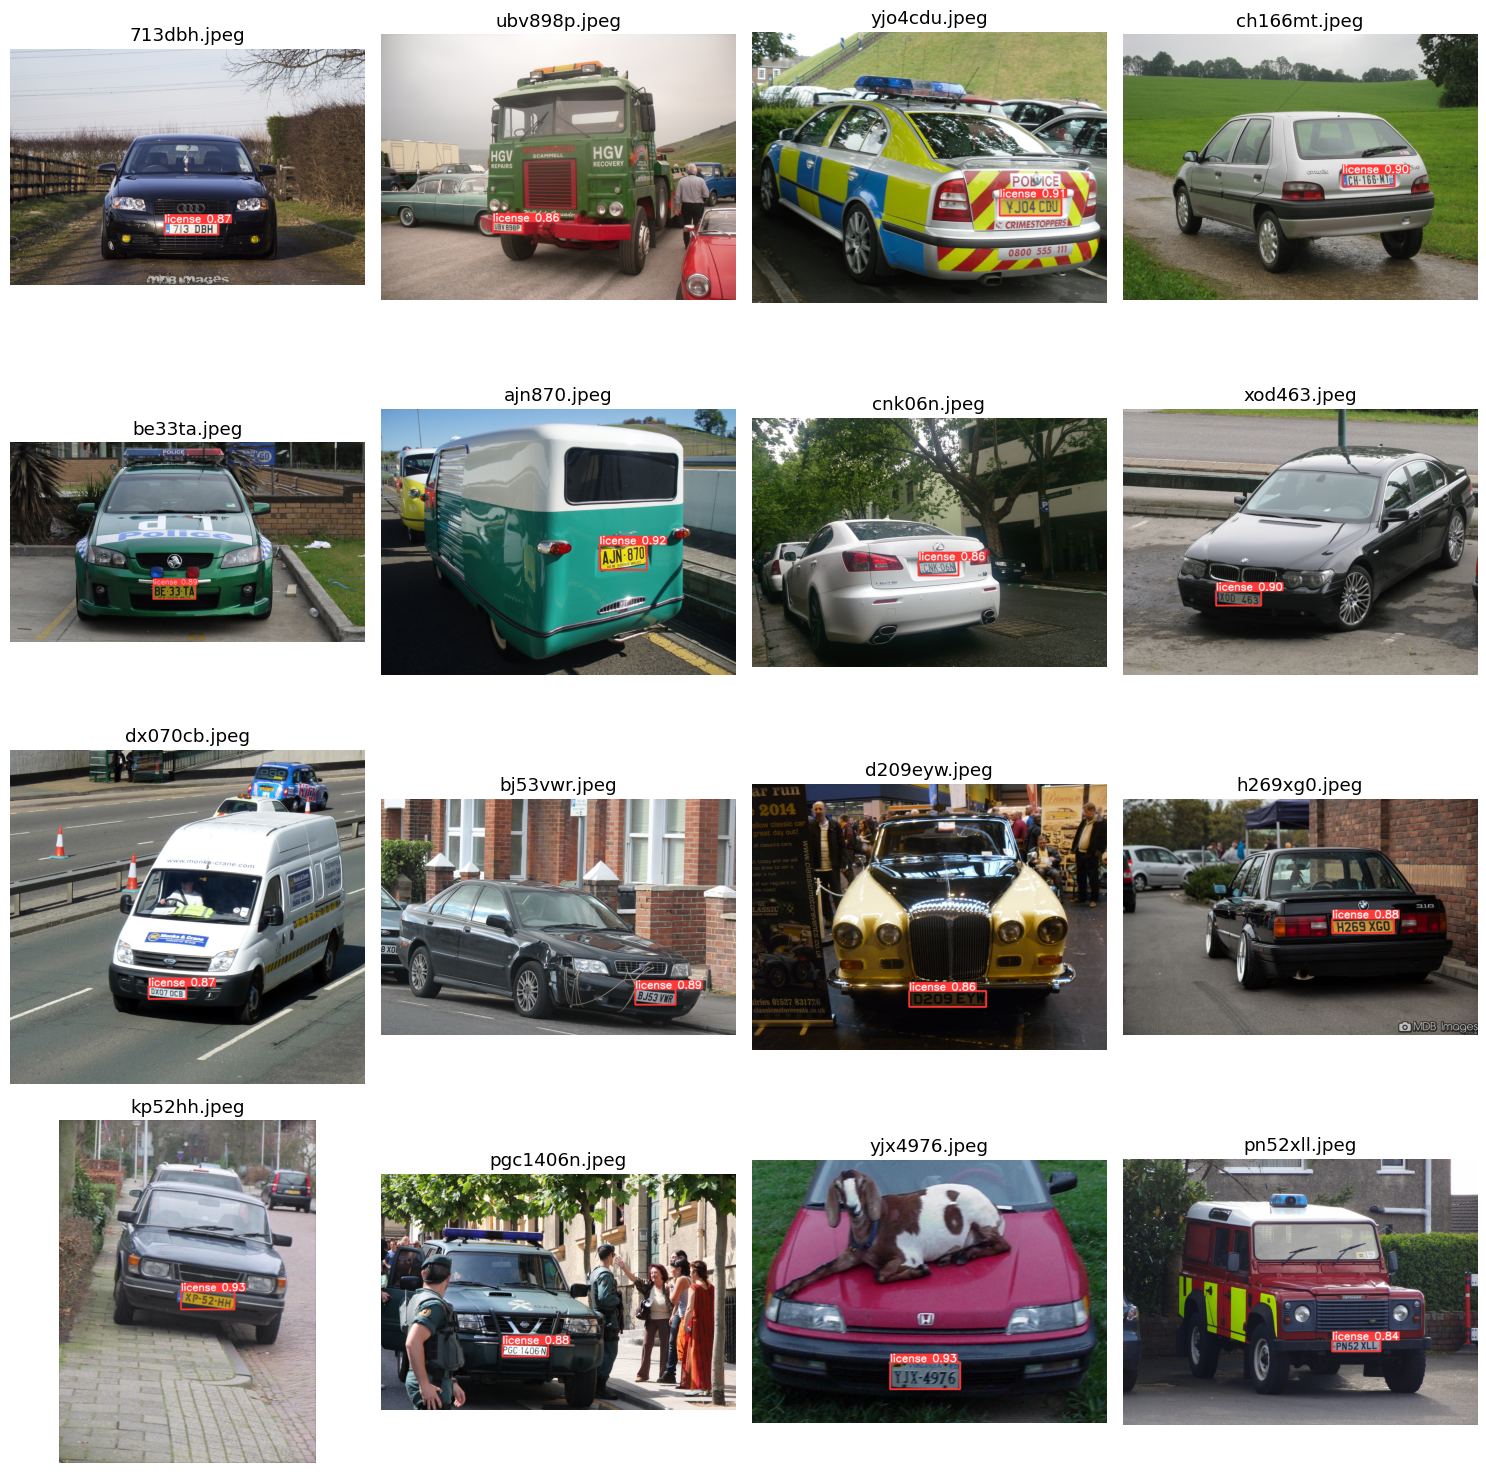

In [57]:
ocr_df = plot_images_with_inference_and_ocr(model, directory)


In [58]:
ocr_df

,File Name,OCR Text
0,713dbh.jpeg,5713DBH
1,ubv898p.jpeg,UBV89aP
2,yjo4cdu.jpeg,JO4CHU
3,ch166mt.jpeg,H166Wle
4,be33ta.jpeg,BE33TA
5,ajn870.jpeg,AN810
6,cnk06n.jpeg,ECNKO6N
7,xod463.jpeg,1XOD463
8,dx070cb.jpeg,DXO7OCB
9,bj53vwr.jpeg,BIS3Vyp
